In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
ds = MNIST('./datasets', download=True, transform=ToTensor())
train_ds = MNIST('./datasets', download=True, train=True, transform=ToTensor())
test_ds = MNIST('./datasets', download=True, train=False, transform=ToTensor())

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [112]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

def show_image(img, title):
    img = img.view(28, 28).cpu().detach().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

class ConvDenoisingAutoencoder(nn.Module):
    def __init__(self, optim_params={'lr': 1e-3}) -> None:
        super().__init__()
        self.error = []
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x14x14 -> 32x7x7
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x7x7 -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x14x14 -> 1x28x28
            nn.Sigmoid()  
        )
        self.optimizer = torch.optim.Adam(self.parameters(), **optim_params)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def fit(self, n_epoch, dataloader, device, noise_factor=0.3):
        model.train(True)
        for epoch in tqdm(range(n_epoch)):
            local_error = 0
            for data in dataloader:
                batch, _ = data
                batch = batch.to(device)
                noisy_batch = batch + noise_factor * torch.randn(batch.shape).to(device)
                noisy_batch = torch.clamp(noisy_batch, 0., 1.)

                self.optimizer.zero_grad()
                val = self.forward(noisy_batch)
                loss = self.criterion(val, batch)
                local_error += loss.item()
                loss.backward()
                self.optimizer.step()
            local_error /= len(dataloader)
            self.error.append(local_error)
            print(f'Epoch [{epoch+1}/{n_epoch}], Loss: {local_error:.4f}')

train_ds = MNIST('./datasets', download=True, train=True, transform=ToTensor())
test_ds = MNIST('./datasets', download=True, train=False, transform=ToTensor())
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvDenoisingAutoencoder().to(device)
model.fit(10, train_loader, device)

torch.save(model.state_dict(), 'denoising_autoencoder.pth')


 10%|█         | 1/10 [00:11<01:43, 11.47s/it]

Epoch [1/10], Loss: 0.0141


 20%|██        | 2/10 [00:21<01:25, 10.64s/it]

Epoch [2/10], Loss: 0.0056


 30%|███       | 3/10 [00:31<01:11, 10.20s/it]

Epoch [3/10], Loss: 0.0053


 40%|████      | 4/10 [00:40<00:59,  9.99s/it]

Epoch [4/10], Loss: 0.0052


 50%|█████     | 5/10 [00:50<00:49,  9.83s/it]

Epoch [5/10], Loss: 0.0051


 60%|██████    | 6/10 [00:59<00:38,  9.73s/it]

Epoch [6/10], Loss: 0.0051


 70%|███████   | 7/10 [01:10<00:30, 10.07s/it]

Epoch [7/10], Loss: 0.0050


 80%|████████  | 8/10 [01:21<00:20, 10.14s/it]

Epoch [8/10], Loss: 0.0050


 90%|█████████ | 9/10 [01:31<00:10, 10.12s/it]

Epoch [9/10], Loss: 0.0050


100%|██████████| 10/10 [01:40<00:00, 10.09s/it]

Epoch [10/10], Loss: 0.0050


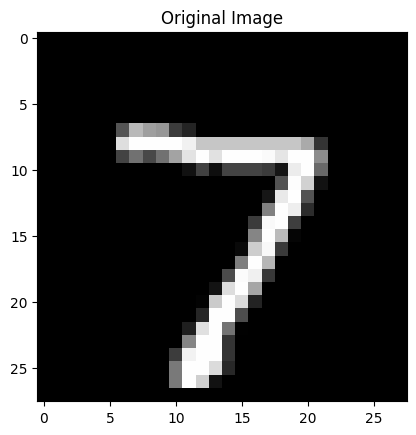

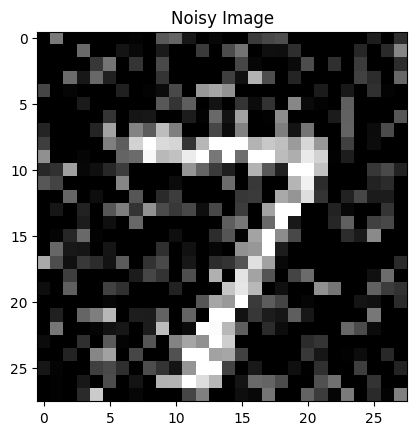

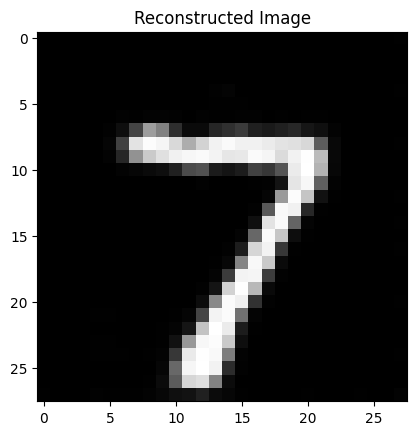

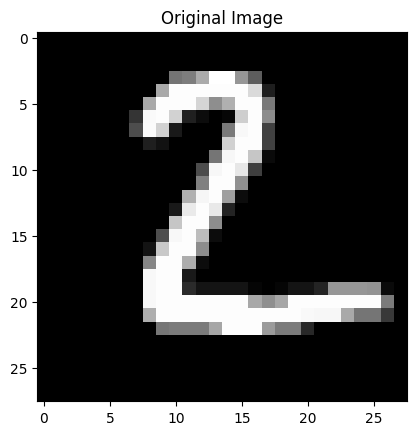

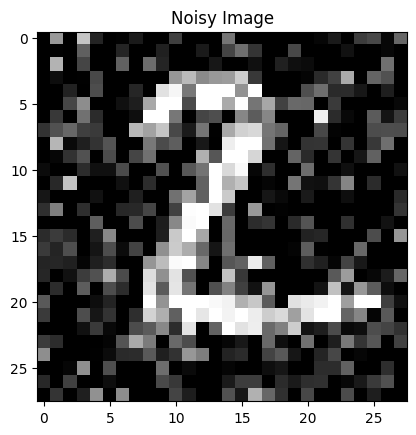

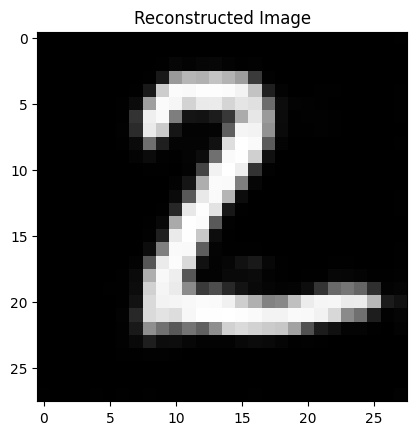

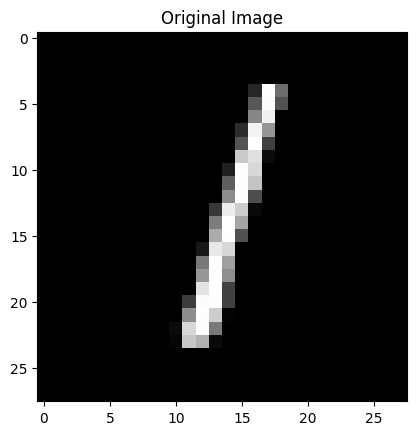

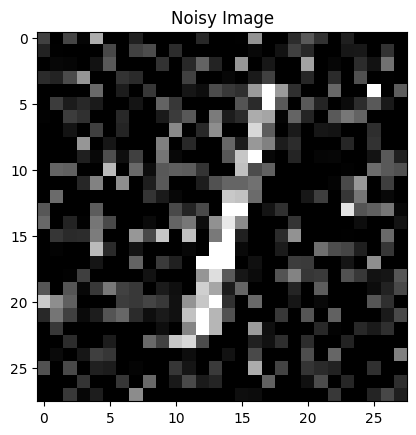

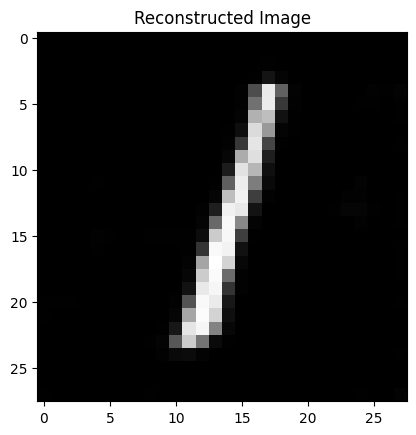

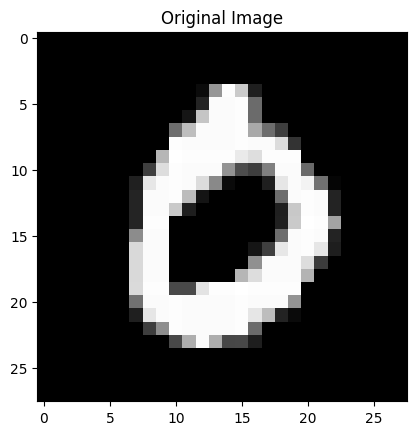

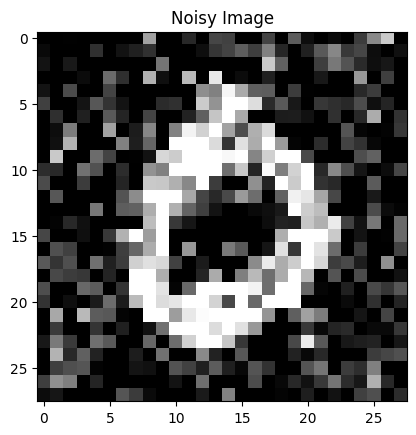

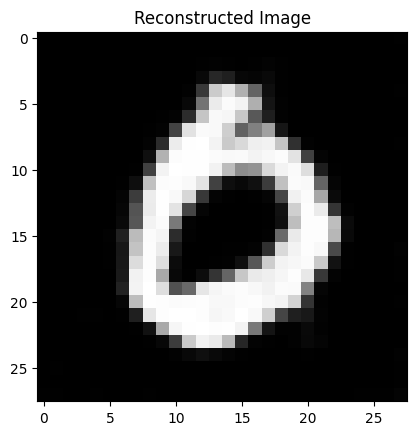

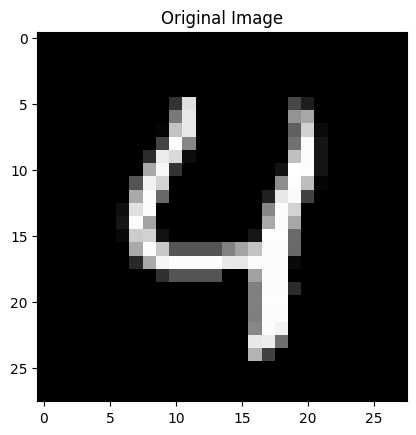

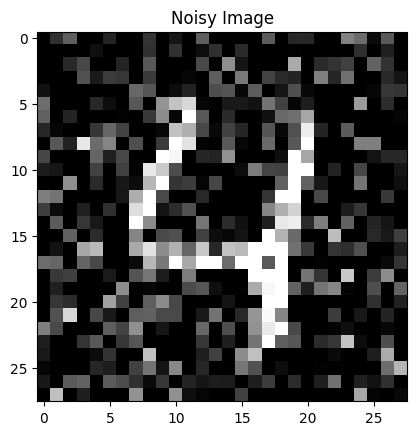

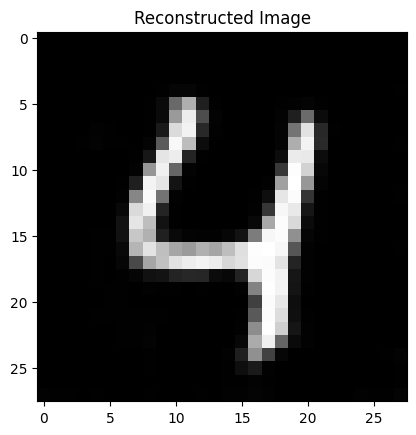

In [113]:
def visualize_results(model, dataloader, device, noise_factor=0.3):
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            batch, _ = data
            batch = batch.to(device)
            noisy_batch = batch + noise_factor * torch.randn(batch.shape).to(device)
            noisy_batch = torch.clamp(noisy_batch, 0., 1.)
            reconstructed = model(noisy_batch)

            for i in range(5):
                show_image(batch[i], title='Original Image')
                show_image(noisy_batch[i], title='Noisy Image')
                show_image(reconstructed[i], title='Reconstructed Image')
            break

visualize_results(model, test_loader, device)

In [114]:
from torch.nn import functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, n_features) -> None:
        super().__init__()
        self.n_features = n_features
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x14x14 -> 32x7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=7),  # 32x7x7 -> 64x1x1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64, self.n_features * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.n_features, out_features=64),
            nn.Unflatten(1, (64, 1, 1)),    
            nn.ConvTranspose2d(64, 32, kernel_size=7),  # 64x1x1 -> 32x7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x7x7 -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x14x14 -> 1x28x28
            nn.Sigmoid()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=3e-3)
        self.error = []
        
    def reparametrize(self, mu, sigma):
        return mu + sigma * torch.randn_like(sigma)
    
    def get_new_params(self, x):
        params = self.encoder(x)
        mu, log_sigma = torch.chunk(params, 2, dim=1)
        sigma = torch.exp(1/2 * log_sigma)
        return mu, sigma

    def get_latent_vector(self, mu, sigma):
        return mu + torch.randn_like(sigma) * sigma
        
    def get_new_image(self, z):
        return self.decoder(z)
    
    def loss(self, input_image, reconstructed_image, mu, sigma):
        BCE = F.binary_cross_entropy(reconstructed_image.view(-1, 784), input_image.view(-1, 784), reduction='sum')
        KLD = -1/2 * torch.sum(1 + torch.log(sigma) - mu.pow(2) - sigma) 
        return (BCE + KLD)
    
    def fit(self, n_epoch, dataloader, device):
        self.to(device)
        self.train(True)
        for epoch in tqdm(range(n_epoch)):
            local_error = 0
            for data in dataloader:
                batch, _ = data
                batch = batch.to(device)
                
                self.optimizer.zero_grad()
                mu, sigma = self.get_new_params(batch)
                z = self.get_latent_vector(mu, sigma)
                new_image = self.get_new_image(z)
                loss = self.loss(batch, new_image, mu, sigma)
                local_error += loss.item()
                loss.backward()
                self.optimizer.step()
            local_error /= len(dataloader)
            self.error.append(local_error)
            print(f'Epoch [{epoch+1}/{n_epoch}], Loss: {local_error:.4f}')        

In [115]:
vae = VariationalAutoencoder(5)
vae.fit(20, loader, device)

  5%|▌         | 1/20 [00:15<04:53, 15.43s/it]

Epoch [1/20], Loss: 4541.2933


 10%|█         | 2/20 [00:30<04:30, 15.04s/it]

Epoch [2/20], Loss: 4095.5976


 15%|█▌        | 3/20 [00:43<04:01, 14.23s/it]

Epoch [3/20], Loss: 4018.8384


 20%|██        | 4/20 [00:57<03:45, 14.12s/it]

Epoch [4/20], Loss: 3977.7880


 25%|██▌       | 5/20 [01:10<03:25, 13.73s/it]

Epoch [5/20], Loss: 3937.0932


 30%|███       | 6/20 [01:24<03:12, 13.78s/it]

Epoch [6/20], Loss: 3910.0716


 35%|███▌      | 7/20 [01:37<02:58, 13.74s/it]

Epoch [7/20], Loss: 3892.6233


 40%|████      | 8/20 [01:53<02:52, 14.40s/it]

Epoch [8/20], Loss: 3869.1849


 45%|████▌     | 9/20 [02:08<02:37, 14.34s/it]

Epoch [9/20], Loss: 3859.1962


 50%|█████     | 10/20 [02:21<02:21, 14.12s/it]

Epoch [10/20], Loss: 3843.7657


 55%|█████▌    | 11/20 [02:36<02:09, 14.35s/it]

Epoch [11/20], Loss: 3832.9106


 60%|██████    | 12/20 [02:51<01:55, 14.40s/it]

Epoch [12/20], Loss: 3824.8852


 65%|██████▌   | 13/20 [03:05<01:41, 14.47s/it]

Epoch [13/20], Loss: 3815.1827


 70%|███████   | 14/20 [03:20<01:27, 14.52s/it]

Epoch [14/20], Loss: 3804.7882


 75%|███████▌  | 15/20 [03:35<01:13, 14.71s/it]

Epoch [15/20], Loss: 3802.6485


 80%|████████  | 16/20 [03:50<00:58, 14.74s/it]

Epoch [16/20], Loss: 3794.5246


 85%|████████▌ | 17/20 [04:04<00:43, 14.53s/it]

Epoch [17/20], Loss: 3782.8200


 90%|█████████ | 18/20 [04:18<00:29, 14.57s/it]

Epoch [18/20], Loss: 3783.1628


 95%|█████████▌| 19/20 [04:34<00:14, 14.72s/it]

Epoch [19/20], Loss: 3775.8658


100%|██████████| 20/20 [04:48<00:00, 14.41s/it]

Epoch [20/20], Loss: 3774.9265


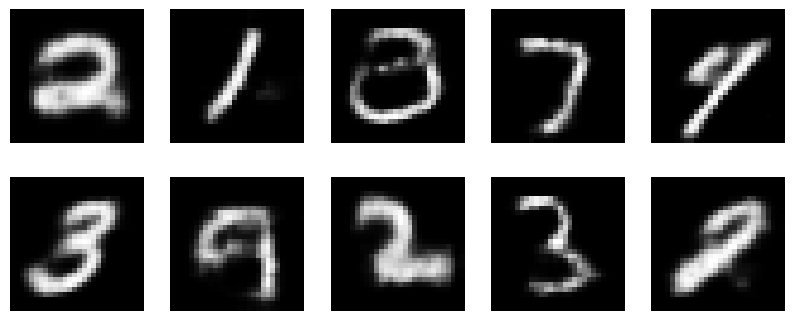

In [132]:
import matplotlib.pyplot as plt

def generate_images(vae, num_images, device):
    vae.eval() 
    with torch.no_grad():
        latent_vectors = torch.randn(num_images, vae.n_features).to(device)
        generated_images = vae.get_new_image(latent_vectors).cpu()
    
    return generated_images

def plot_images(images, n_rows, n_cols):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

num_images = 10
generated_images = generate_images(vae, num_images, device)
plot_images(generated_images, n_rows=2, n_cols=5)


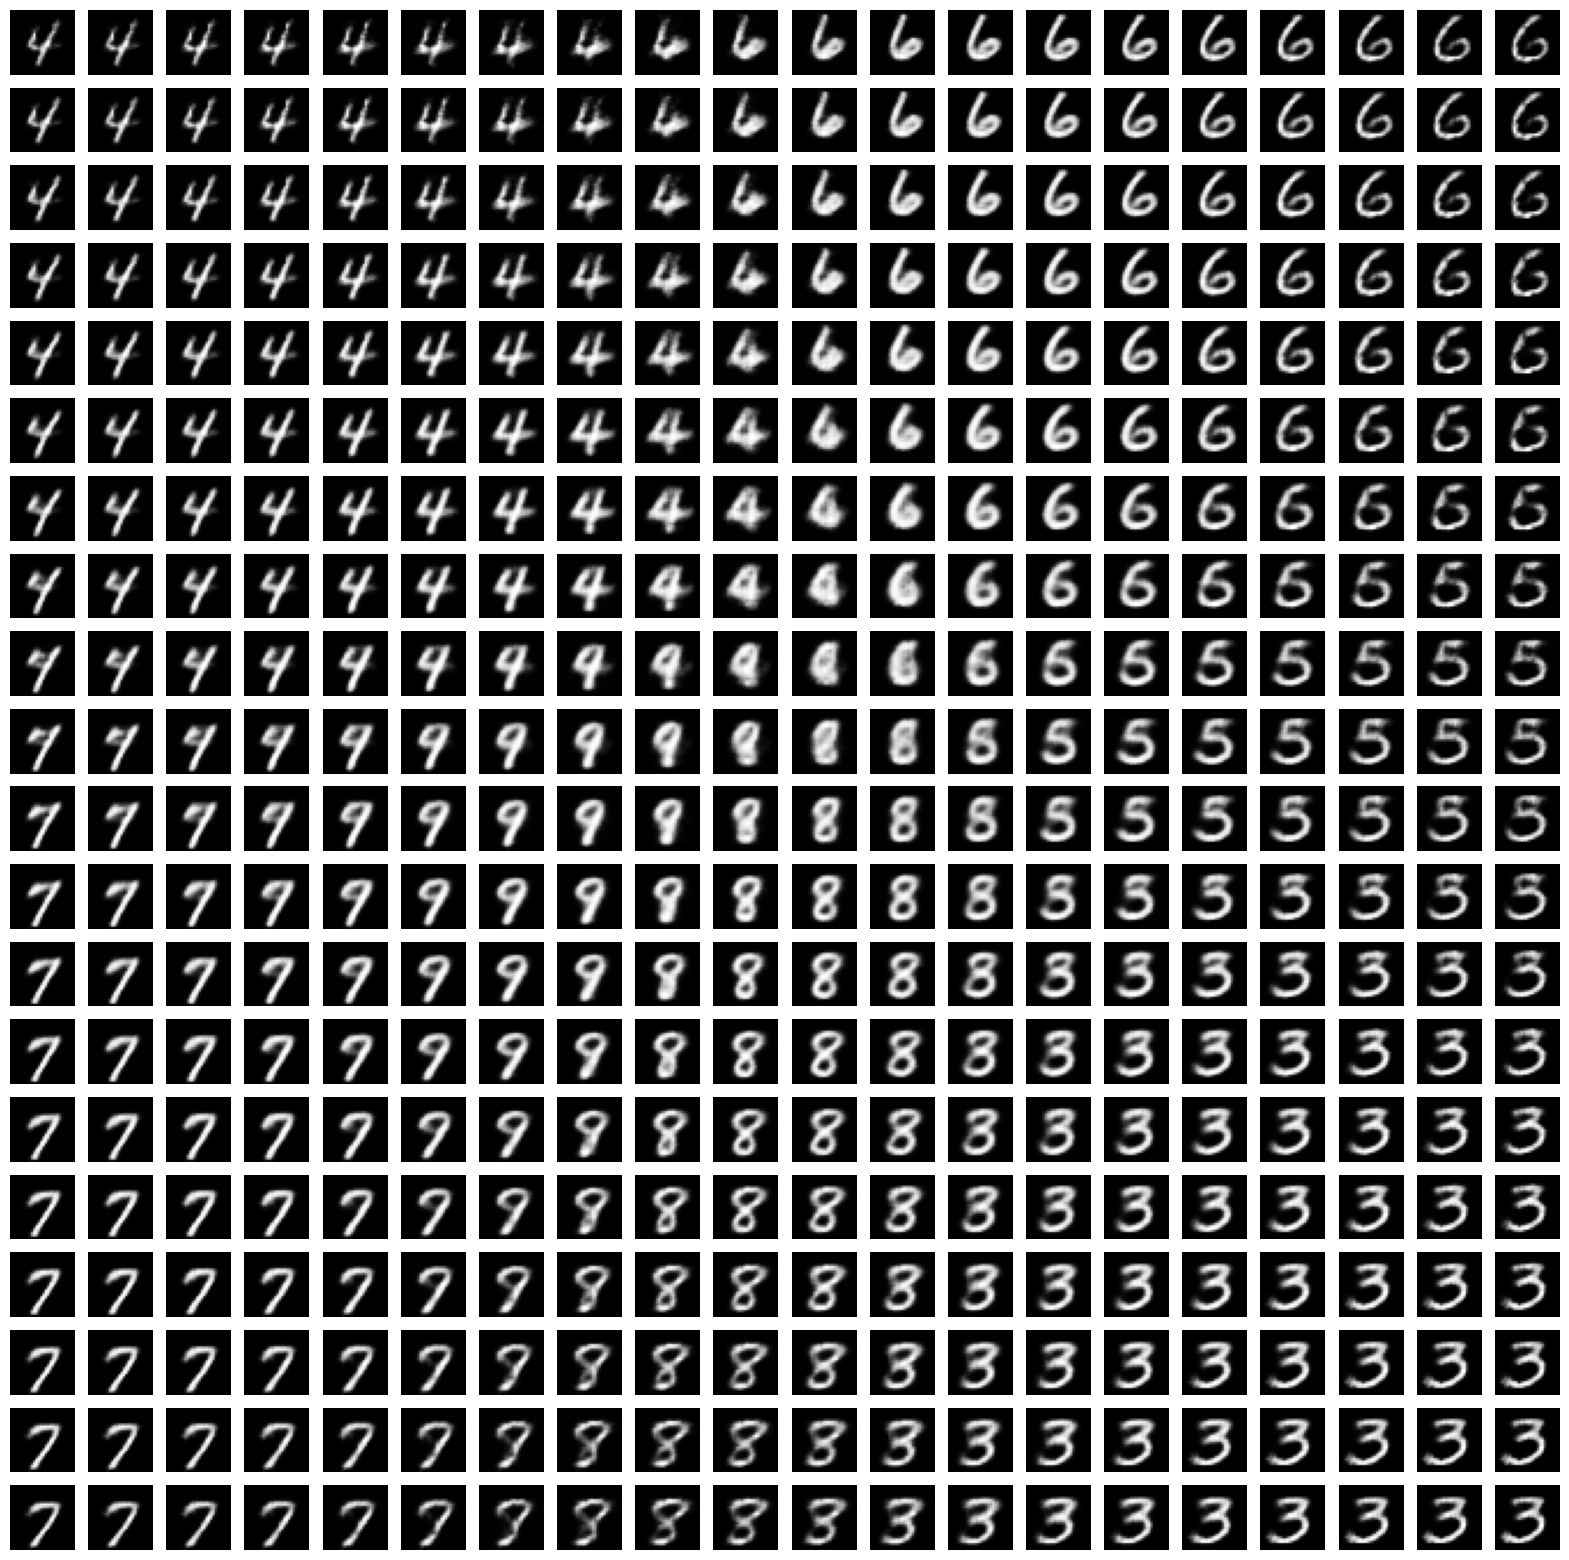

In [118]:
import torch
import matplotlib.pyplot as plt

def visualize_latent_grid(vae, grid_size, range_min, range_max, device):
    vae.eval()  
    with torch.no_grad():  
        linspace = torch.linspace(range_min, range_max, grid_size)
        grid_x, grid_y = torch.meshgrid(linspace, linspace)
        latent_vectors = torch.zeros((grid_size * grid_size, vae.n_features)).to(device)
        
        latent_vectors[:, 0] = grid_x.flatten()
        latent_vectors[:, 1] = grid_y.flatten()
        generated_images = vae.get_new_image(latent_vectors).cpu()
        
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                axes[i, j].imshow(generated_images[idx][0], cmap='gray')
                axes[i, j].axis('off')
        plt.show()

grid_size = 20
range_min = -2
range_max = 2

visualize_latent_grid(vae, grid_size, range_min, range_max, device)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class VariationalAutoencoder(nn.Module):
    def __init__(self, n_input_features, latent_dim, encoder_neuron_list, decoder_neuron_list) -> None:
        super().__init__()
        self.n_input_features = n_input_features
        self.latent_dim = latent_dim
        self.encoder_neuron_list = encoder_neuron_list
        self.decoder_neuron_list = decoder_neuron_list

        self.error = []
        self._build_encoder()
        self._build_decoder()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=3e-3)

    def _build_encoder(self):
        encoder_list = []
        encoder_list.append(nn.Linear(self.n_input_features, self.encoder_neuron_list[0]))
        encoder_list.append(nn.BatchNorm1d(self.encoder_neuron_list[0]))
        encoder_list.append(nn.ReLU())

        for i in range(0, len(self.encoder_neuron_list) - 1):
            encoder_list.append(nn.Linear(self.encoder_neuron_list[i], self.encoder_neuron_list[i+1]))
            encoder_list.append(nn.BatchNorm1d(self.encoder_neuron_list[i+1]))
            encoder_list.append(nn.ReLU())

        encoder_list.append(nn.Linear(self.encoder_neuron_list[-1], 2 * self.latent_dim))
        self.encoder = nn.Sequential(*encoder_list)
        
    def _build_decoder(self):
        decoder_list = []
        decoder_list.append(nn.Linear(self.latent_dim, self.decoder_neuron_list[0]))
        decoder_list.append(nn.BatchNorm1d(self.decoder_neuron_list[0]))
        decoder_list.append(nn.ReLU())

        for i in range(0, len(self.decoder_neuron_list) - 1):
            decoder_list.append(nn.Linear(self.decoder_neuron_list[i], self.decoder_neuron_list[i+1]))
            decoder_list.append(nn.BatchNorm1d(self.decoder_neuron_list[i+1]))
            decoder_list.append(nn.ReLU())

        decoder_list.append(nn.Linear(self.decoder_neuron_list[-1], self.n_input_features))
        decoder_list.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_list)
        
    def reparametrize(self, mu, sigma):
        return mu + sigma * torch.randn_like(sigma)
    
    def get_new_params(self, x):
        params = self.encoder(x)
        mu, log_sigma = torch.chunk(params, 2, dim=1)
        sigma = torch.exp(0.5 * log_sigma)
        return mu, sigma

    def get_latent_vector(self, mu, sigma):
        return mu + torch.randn_like(sigma) * sigma
        
    def get_new_image(self, z):
        return self.decoder(z)
    
    def loss(self, input_vec, reconstructed_vec, mu, sigma):
        BCE = F.binary_cross_entropy(reconstructed_vec.view(-1, self.n_input_features), input_vec.view(-1, self.n_input_features), reduction='sum')
        KLD = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma.pow(2))
        return BCE + KLD
    
    def fit(self, n_epoch, dataloader, device):
        self.train(True)
        for epoch in tqdm(range(n_epoch)):
            local_error = 0
            for data in dataloader:
                batch, _ = data
                batch = batch.to(device).view(-1, self.n_input_features) 
                
                self.optimizer.zero_grad()
                mu, sigma = self.get_new_params(batch)
                
                z = self.get_latent_vector(mu, sigma)                
                new_image = self.get_new_image(z)
                
                loss = self.loss(batch, new_image, mu, sigma)
                local_error += loss.item()
                loss.backward()
                self.optimizer.step()
            local_error /= len(dataloader)
            self.error.append(local_error)
            print(f'Epoch [{epoch+1}/{n_epoch}], Loss: {local_error:.4f}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(784, 10, [256, 128], [128, 256])
vae.to(device)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [37]:
vae.fit(5, loader, device)

 20%|██        | 1/5 [00:23<01:35, 23.84s/it]

Epoch [1/5], Loss: 3680.2649


 40%|████      | 2/5 [00:46<01:09, 23.12s/it]

Epoch [2/5], Loss: 3660.3409


 60%|██████    | 3/5 [01:05<00:42, 21.41s/it]

Epoch [3/5], Loss: 3647.8902


 80%|████████  | 4/5 [01:26<00:21, 21.02s/it]

Epoch [4/5], Loss: 3638.1541


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]

Epoch [5/5], Loss: 3624.5398
